<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/Cant_Stop_Tournament_ELO_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as jnp
import pandas as pd
import jax

In [ ]:
x = jnp.array([
[ 0.,           77.4597168, 62.62817383, 54.9621582,  39.30664062, 46.08764648, 46.77124023, 71.23413086, 35.88867188, 34.41772461],
 [26.02539062,   0.       , 48.44970703, 32.8704834,  27.85644531, 36.22436523, 33.58154297, 54.63867188, 20.67260742, 19.08569336],
 [42.34008789, 55.75561523, 0.         , 40.3503418,  37.97607422, 47.34497070,  42.88330078, 51.4831543,  32.76977539, 27.33154297],
 [52.29492188, 71.46606445, 62.27416992,  0.       ,  51.84936523, 57.92846680,  46.00219727, 67.20275879, 40.92407227, 36.88354492],
 [72.33886719, 77.62451172, 66.27197266, 59.05151367, 0.         , 74.90844727, 63.16528320, 67.41333008, 50.57983398, 57.33642578],
 [66.07055664, 68.98803711, 58.38012695, 49.67651367, 34.38110352,  0.        , 51.01013184, 62.27416992, 41.76635742, 35.96801758],
 [60.77880859, 69.98901367, 62.60986328, 59.12475586, 45.00427246, 55.60913086, 0.        , 64.72167969, 45.09887695, 49.48120117],
 [34.13085938, 48.38867188, 51.08642578, 36.04125977, 35.86425781, 43.34106445, 40.27099609,  0.        , 25.2746582,  21.5423584 ],
 [72.03979492, 82.67211914, 72.14355469, 66.36352539, 57.75146484, 66.54663086, 61.03515625, 77.62451172,  0.        , 56.76269531],
 [74.76196289, 83.40759277, 74.67041016, 70.23620605, 54.31518555, 74.32861328, 56.5612793,  80.53894043, 52.87475586,  0.        ]])

asymmetric_tournament_results = x/100

symmetric_tournament_results = 0.5*(x + (100-x).T)/100

In [ ]:
runner_weights_winrate = symmetric_tournament_results.T[0]

In [ ]:
print(symmetric_tournament_results)

[[0.5        0.75717163 0.6014404  0.5133362  0.33483887 0.40008545
  0.42996216 0.68551636 0.31924438 0.2982788 ]
 [0.24282837 0.5        0.46347046 0.3070221  0.25115967 0.33618164
  0.31796265 0.53125    0.19000244 0.1783905 ]
 [0.39855957 0.53652954 0.5        0.39038086 0.3585205  0.44482422
  0.4013672  0.50198364 0.3031311  0.26330566]
 [0.48666382 0.6929779  0.60961914 0.5        0.46398926 0.54125977
  0.4343872  0.6558075  0.37280273 0.3332367 ]
 [0.66516113 0.74884033 0.6414795  0.53601074 0.5        0.7026367
  0.59080505 0.65774536 0.46414185 0.5151062 ]
 [0.59991455 0.66381836 0.5551758  0.45874023 0.29736328 0.5
  0.477005   0.5946655  0.37609863 0.30819702]
 [0.57003784 0.68203735 0.5986328  0.5656128  0.40919495 0.522995
  0.5        0.6222534  0.4203186  0.4645996 ]
 [0.31448364 0.46875    0.49801636 0.3441925  0.34225464 0.40533447
  0.37774658 0.5        0.23825073 0.20501709]
 [0.6807556  0.80999756 0.6968689  0.62719727 0.53585815 0.62390137
  0.5796814  0.7617492

In [ ]:
df = pd.DataFrame(asymmetric_tournament_results)

In [ ]:
df = pd.DataFrame (symmetric_tournament_results)

# ELO Scores

The ELO formula for the expected score for player $A$ when the ratings are $R_A$ and $R_B$ is (from Wikipedia: https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)

$$E_{A}= \frac{1}{ 1+10^{ (R_B-R_A )/400 }   }$$

In [ ]:
@jax.jit
def expected_scores(ELO_ratings):
  #Input: Elo vector of size (N,)
  #Output: An (N,N) matrix with the expected tournament scores according to the ELO formula
  return 1/(1+jnp.power(10, (ELO_ratings[jnp.newaxis,:] - ELO_ratings[:,jnp.newaxis]) /400)) 

In [ ]:
ELO_ratings = jnp.array([100,500,900])

expected_scores(ELO_ratings)

DeviceArray([[0.5       , 0.09090909, 0.00990099],
             [0.9090909 , 0.5       , 0.09090909],
             [0.990099  , 0.9090909 , 0.5       ]], dtype=float32)

# Loss functions

These are different ways to evaluate how close a set of ELO ratings predicts the actual scores.

In [ ]:
@jax.jit
def L2_loss(ELO_ratings,actual_scores):
  #The L2 loss of the difference between the expected scores generated by some ELO_ratings and the actual scores
  return jnp.mean( (expected_scores(ELO_ratings) - actual_scores)**2 )

In [ ]:
@jax.jit
def CE_loss(ELO_ratings, actual_scores):
  #Note that we only need to put in the term for phat*log(p), the complementary term is handled at the (j,i) entry of the matrix
  return jnp.sum( -actual_scores*jnp.log(expected_scores(ELO_ratings))  )

In [ ]:
@jax.jit
def KL_loss(ELO_ratings,actual_scores):
  #The L2 loss of the difference between the expected scores generated by some ELO_ratings and the actual scores
  pred = expected_scores(ELO_ratings)
  return jnp.mean( pred*jnp.log(pred/actual_scores) )

grad_KL_loss = jax.jit(jax.grad(KL_loss,argnums=0)) 

In [ ]:
def tournament_to_ELO(sym_tourny_results, loss_func):
  #Given a square matrix M of shape (N,N), compute a vector of size (N,) with the ELO scores for the N players
  N = jnp.shape(sym_tourny_results)[0]
  grad_loss = jax.jit(jax.grad(loss_func,argnums=0)) 
  ELO_ratings = jnp.zeros(N)
  learning_rate = 100
  N_epochs = 100000
  for i in range(N_epochs):
    ELO_ratings -= learning_rate*grad_loss(ELO_ratings, sym_tourny_results)
    if i % (N_epochs//3) == 0:
      #learning_rate /= 1.5
      print(f"Epoch {i}:")
      #print("ELO ratings:\n", ELO_ratings)
      print("Loss func: ",loss_func(ELO_ratings,sym_tourny_results))

  ELO_ratings = ELO_ratings - ELO_ratings[0]

  errors = 100*(expected_scores(ELO_ratings) - sym_tourny_results)
  print("Final percent errors:\n", errors )
  print("Row sums:\n ", jnp.sum(errors, axis=0))
  print("Final ELOs:", ELO_ratings)
  return ELO_ratings


In [ ]:
runner_weights_winrate = symmetric_tournament_results.T[0]

In [ ]:
jnp.set_printoptions(precision=2)
ELO_L2 = tournament_to_ELO(symmetric_tournament_results, L2_loss)

Epoch 0:
Loss func:  0.022366151
Epoch 33333:
Loss func:  0.0018584752
Epoch 66666:
Loss func:  0.0016589917
Epoch 99999:
Loss func:  0.0016546207
Final percent errors:
 [[  0.   -10.01  -2.29  -3.97   4.     9.97   1.5   -6.48   2.63   4.18]
 [ 10.01   0.    -4.61   1.25  -1.28   0.65  -2.3   -7.06   2.6    3.36]
 [  2.29   4.61   0.     0.55  -5.45  -2.36  -3.27   4.18  -2.53   0.96]
 [  3.97  -1.25  -0.55   0.    -6.41  -1.51   3.68  -1.05  -0.3    3.1 ]
 [ -4.     1.28   5.45   6.41   0.    -7.77  -1.87   7.41   0.41  -5.29]
 [ -9.97  -0.65   2.36   1.51   7.77   0.    -3.19   2.63  -3.03   3.21]
 [ -1.5    2.3    3.27  -3.68   1.87   3.19   0.     4.9   -2.32  -7.32]
 [  6.48   7.06  -4.18   1.05  -7.41  -2.63  -4.9    0.     0.57   3.45]
 [ -2.63  -2.6    2.53   0.3   -0.41   3.03   2.32  -0.57   0.    -2.55]
 [ -4.18  -3.36  -0.96  -3.1    5.29  -3.21   7.32  -3.45   2.55   0.  ]]
Row sums:
  [ 0.47 -2.61  1.03  0.32 -2.04 -0.64 -0.72  0.5   0.59  3.1 ]
Final ELOs: [   0.   -112

In [ ]:
ELO_KL = tournament_to_ELO(symmetric_tournament_results, KL_loss)

Epoch 0:
Loss func:  0.02535717
Epoch 33333:
Loss func:  0.0019579602
Epoch 66666:
Loss func:  0.0018236951
Epoch 99999:
Loss func:  0.0018222706
Final percent errors:
 [[  0.    -9.47  -2.24  -3.86   4.18  10.2    1.69  -6.3    2.65   3.89]
 [  9.47   0.    -5.14   0.83  -1.58   0.33  -2.64  -7.46   2.22   2.75]
 [  2.24   5.14   0.     0.61  -5.33  -2.18  -3.14   4.33  -2.56   0.67]
 [  3.86  -0.83  -0.61   0.    -6.33  -1.39   3.76  -0.97  -0.38   2.7 ]
 [ -4.18   1.58   5.33   6.33   0.    -7.73  -1.87   7.42   0.24  -5.79]
 [-10.2   -0.33   2.18   1.39   7.73   0.    -3.23   2.59  -3.22   2.72]
 [ -1.69   2.64   3.14  -3.76   1.87   3.23   0.     4.9   -2.48  -7.81]
 [  6.3    7.46  -4.33   0.97  -7.42  -2.59  -4.9    0.     0.44   3.07]
 [ -2.65  -2.22   2.56   0.38  -0.24   3.22   2.48  -0.44   0.    -2.89]
 [ -3.89  -2.75  -0.67  -2.7    5.79  -2.72   7.81  -3.07   2.89   0.  ]]
Row sums:
  [-0.74  1.22  0.22  0.18 -1.32  0.37 -0.04  1.   -0.19 -0.69]
Final ELOs: [   0.   -117.

In [ ]:
ELO_CE = tournament_to_ELO(symmetric_tournament_results, CE_loss)

Epoch 0:
Loss func:  34.623154
Epoch 33333:
Loss func:  32.510326
Epoch 66666:
Loss func:  32.510326
Epoch 99999:
Loss func:  32.510326
Final percent errors:
 [[  0.    -9.68  -2.34  -3.96   4.25  10.08   1.62  -6.48   2.61   3.9 ]
 [  9.68   0.    -5.02   0.94  -1.36   0.43  -2.5   -7.42   2.34   2.91]
 [  2.34   5.02   0.     0.62  -5.18  -2.19  -3.11   4.24  -2.51   0.76]
 [  3.96  -0.94  -0.62   0.    -6.17  -1.41   3.78  -1.07  -0.33   2.8 ]
 [ -4.25   1.36   5.18   6.17   0.    -7.91  -2.01   7.2    0.12  -5.86]
 [-10.08  -0.43   2.19   1.41   7.91   0.    -3.18   2.52  -3.16   2.83]
 [ -1.62   2.5    3.11  -3.78   2.01   3.18   0.     4.79  -2.46  -7.74]
 [  6.48   7.42  -4.24   1.07  -7.2   -2.52  -4.79   0.     0.55   3.22]
 [ -2.61  -2.34   2.51   0.33  -0.12   3.16   2.46  -0.55   0.    -2.83]
 [ -3.9   -2.91  -0.76  -2.8    5.86  -2.83   7.74  -3.22   2.83   0.  ]]
Row sums:
  [-4.41e-05 -6.44e-04 -6.52e-04  3.24e-05  6.11e-04 -3.86e-05  1.25e-04
 -6.59e-04  5.96e-04  6.41e

In [ ]:
df = pd.DataFrame([ELO_L2, ELO_KL, ELO_CE])

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.0,-112.98691,-55.051956,18.355057,88.85377,0.16009235,38.426003,-85.57306,110.926254,115.1429
1,0.0,-117.1149,-55.381134,17.603731,87.53292,-1.4575672,37.09562,-86.93633,110.787506,117.376884
2,0.0,-115.511894,-54.647133,18.261086,87.01673,-0.64810276,37.57982,-85.564865,111.10844,117.30034


# Plots


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
round_ELO = round( ELO_L2 + 500 )
print(round_ELO)

[500 387 445 518 589 500 538 414 611 615]


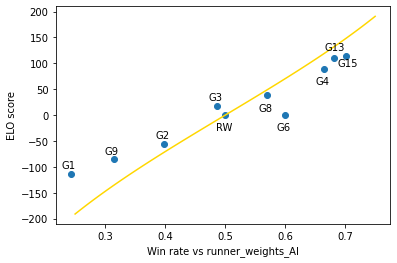

In [ ]:
ELO = ELO_L2

fig, ax = plt.subplots()

p = jnp.linspace(0.25,0.75,100)
rating = 400*jnp.log10(p/(1-p))

runner_weights_winrate = symmetric_tournament_results.T[0]

ax.set_xlabel("Win rate vs runner_weights_AI")
ax.set_ylabel("ELO score")
ax.plot(p,rating, color='gold')
ax.scatter(runner_weights_winrate,ELO)
names = ["RW", "G1", "G2", "G3", "G4", "G6", "G8", "G9", "G13", "G15"]
y_off = [-30, 10, 10, 10, -30, -30, -30, 10, 15, -20]
for i, txt in enumerate(names):
    ax.annotate(txt, (runner_weights_winrate[i] - 0.015, ELO_L2[i]+y_off[i]))

fig = plt.gcf()
fig.savefig('Tourny_results.png', dpi=300)
